In [1]:
import torch
torch.set_grad_enabled(False)
import sys
import time
import random
import csv
import numpy as np
import threading


import scipy.io
from scipy.io import loadmat

import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

import copy
# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')




Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


### In this notebook we evaluate the performance on of the active loop compared to the randomly picked images one.
To compare two models we dont use the r2 score but their loglikeligood value. 
As a reference, we have a model trained on the "whole" dataset, of around 2200 images. 
The remaining 1000 are kept as a test set. 
This model is trained with ntilde=ntrain so we expect the maximum performance on it.


Our **active model** will instead start with 50=ntilde=ntrain and increment the number of images based on their utility until ntilde=300.
The model will then try to calculate the loglikelihood at each iteration ( number of inducing points ) of the same test set of 1000 images. 
To have a good estimation of its performance on the **fixed 1000 imgs test set** we should run 10 different iterations of the above 2 lines, **changing the starting 50 inducing points**.

Here are the main things to control for when comparing performance.

- **Cell number** -> there is huge variability from cell to cell, does closed loop work on average over those?
- **Starting inducing points** -> The starting dataset of inducing points on which we trained the initial model makes a negligible difference or not? This effect needs to be averaged out both in the active and random case. 
- **Number of starting inducing points** -> Is the effect enhanced by changing the dataset size? (10 - 20 - 50 starting dataset)

There are also some parameters of the training of which we need to find the best combination.
- Mstep       -> In the experiment, for time constraint reasons, there is no Hyperparameter optimization. Does this influence the closed loop efficacy?
- **nIterations** -> How many iterations are needed for convergence of each model?
- Ntilde      -> Does the number of inducing points grow indefinitely with the training set. Should it stop earlier?

There are also important checks to perform:
- Does the performance of the active and random loop converge to the same values for the likelihood when using the **complete dataset**? Is it the same as the model directly trained on the complete dataset? -> Point [1] below
- Is the hyperparameters choice sensible given the cell STA? In the previous notebook "one_cell_active_training.ipynb" we did not plot any STA to keep it clean.

The latter can probably only be tested point by point only in the no Mstep case, since for now a 2000 inducing point model with mstep takes a bit more than 10 minutes.



### Tests that I ran so far.
So far I run tests with 2 cells. Number 8 and number 14. One looks promising, one doesn't.

The following are Delta Log Likelihoods of models trained on the two models with **M-Step Hyperparameters Optimization** [ First row ] and wthout it [ second row ]

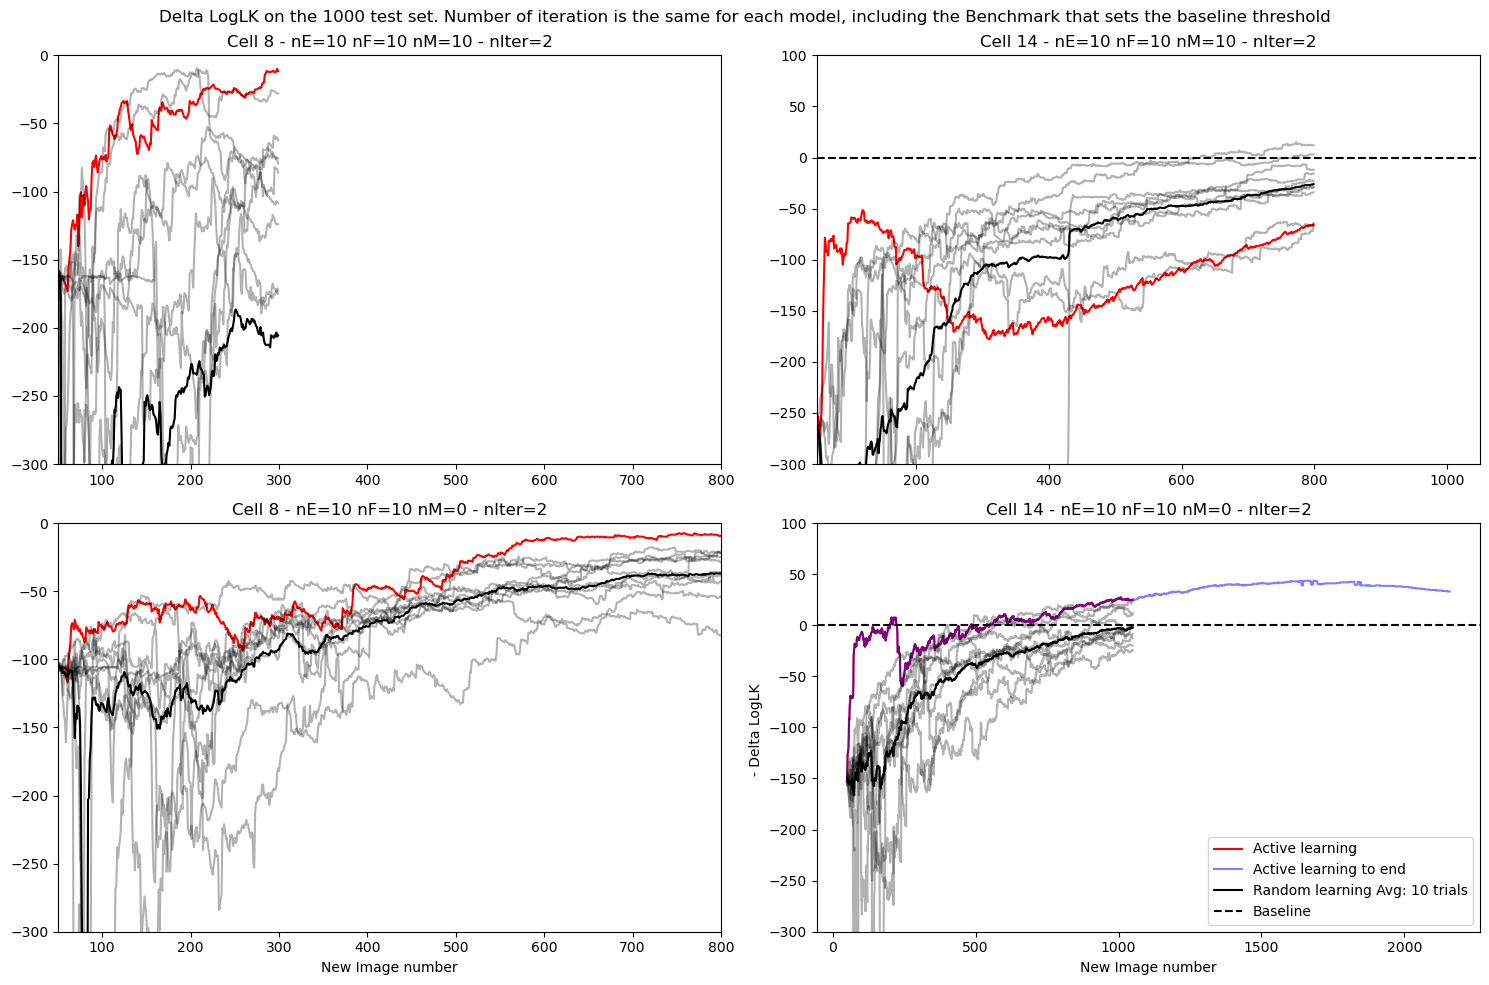

In [2]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), )#sharex=True)

# region ___________Cell 8  - with M-Step ___________
with open('data/loglk_test_1000_active_cell_8_nstart_50_to_300.pkl', 'rb') as f:
    loglk_cell8_test_1000_active = pickle.load(f)

# Upload the random loop likelihood
# with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_1000.pkl', 'rb') as file:
with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_300.pkl', 'rb') as f:
    loglk_cell8_test_1000_random = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_8.pkl', 'rb') as f:
    loglk_cell8_test_1000_max = pickle.load(f)


xrange = np.arange(50, 50+250)

axes[0,0].plot(xrange, loglk_cell8_test_1000_active.cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell8_test_1000_random.shape[0]):
    axes[0,0].plot(xrange, loglk_cell8_test_1000_random[i,:].cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[0,0].plot(xrange, loglk_cell8_test_1000_random.mean(0).cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[0,0].set_ylim(-300,0)
axes[0,0].set_xlim(50,800)
axes[0,0].set_title(f'Cell {8} - nE={10} nF={10} nM={10} - nIter=2')
# endregion

# region ___________Cell 8  - no M-Step ___________
with open('data/loglk_test_1000_active_cell_8_nstart_50_to_800_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_active = pickle.load(f)

# Upload the random loop likelihood
# with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_1000.pkl', 'rb') as file:
with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_800_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_random = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_8_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_max = pickle.load(f)


xrange = np.arange(50, 50+750)

axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_active.cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell8_noM_test_1000_random.shape[0]):
    axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_random[i,:].cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_random.mean(0).cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[1,0].set_ylim(-300,0)
axes[1,0].set_xlim(50,800)
axes[1,0].set_title(f'Cell {8} - nE={10} nF={10} nM={0} - nIter=2')
axes[1,0].set_xlabel('New Image number')
# endregion

# region ___________Cell 14 - with M-Step ___________
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_800.pkl', 'rb') as f:
    loglk_cell14_test_1000_active = pickle.load(f)
with open(f'data/loglk_test_1000_random_cell_14_nstart_50_to_800.pkl', 'rb') as f:
    loglk_cell14_test_1000_random = pickle.load(f)
with open('data/loglk_test_1000_max_cell_14.pkl', 'rb') as f:
    loglk_cell14_test_1000_max = pickle.load(f)

xrange = np.arange(50, 50+750)

axes[0,1].plot(xrange, loglk_cell14_test_1000_active.cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell14_test_1000_random.shape[0]):
    axes[0,1].plot(xrange, loglk_cell14_test_1000_random[i,:].cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[0,1].plot(xrange, loglk_cell14_test_1000_random.mean(0).cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[0,1].set_ylim(-300,100)
axes[0,1].set_xlim(50,1050)
axes[0,1].set_title(f'Cell {14} - nE={10} nF={10} nM={10} - nIter=2')
axes[0,1].axhline(y=0, color='black', linestyle='--', label='Baseline')
# endregion

# region ___________Cell 14 - no M-Step ___________
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_1050_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_active = pickle.load(f)
with open(f'data/loglk_test_1000_random_cell_14_nstart_50_to_1050_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_random = pickle.load(f)
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_2160_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_active_toend = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_14_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_max = pickle.load(f)

xrange = np.arange(50, 50+1000)
xrange_toend = np.arange(50, 2160)

axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_active.cpu().numpy()-loglk_cell14_noM_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
axes[1,1].plot(xrange_toend, loglk_cell14_noM_test_1000_active_toend.cpu().numpy()-loglk_cell14_noM_test_1000_max.cpu().numpy(), 
               label='Active learning to end', color='blue', alpha=0.5)

for i in range(loglk_cell14_noM_test_1000_random.shape[0]):
    axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_random[i,:].cpu().numpy()-loglk_cell14_noM_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     
# Plot the loglk random averaged over rows
axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_random.mean(0).cpu().numpy()-loglk_cell14_noM_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[1,1].set_ylim(-300,100)
# axes[1,1].set_xlim(50,1050)
axes[1,1].set_title(f'Cell {14} - nE={10} nF={10} nM={0} - nIter=2')
axes[1,1].axhline(y=0, color='black', linestyle='--', label='Baseline')
axes[1,1].set_xlabel('New Image number')
# endregion
plt.legend()

plt.ylabel('- Delta LogLK ')
fig.suptitle('Delta LogLK on the 1000 test set. Number of iteration is the same for each model, including the Benchmark that sets the baseline threshold')
plt.tight_layout()

Here we can observe 2 important things.

- Cell variablility is huge
- Maybe even more importantly: The best performance that we use as reference, the one evaluated on the complete max dataset, is too low. [Lower right plot]

In cell 14 we see that the logLK for the loops surpasses the " benchmark " one.

The reason for this is that the above models where all run with **nIterations = 3**  and the benchmark model did not hav ethe time to reach the right variational parameters. It results in fact that:

```active_model m_b mean() = 4.381720158410237```
```active_model V_b mean() = 3.508403057914423```

```benchmark    m_b mean() = 14.832865572739237```
```benchmark    V_b mean() = 48.07527707910861```

For models with same hyperparameters and dataset. The only difference was the starting condition for the variational hyperparameters.

When recalculating the benchmark performance allowing for 20 or more iterations the plots paint the expected picture:

### 1. Does the number of iteration make a difference?
Yes, the Benchmark model needs more than 2 iterations in the noMstep setting to have the same performance of the looped one


torch.Size([10, 500])


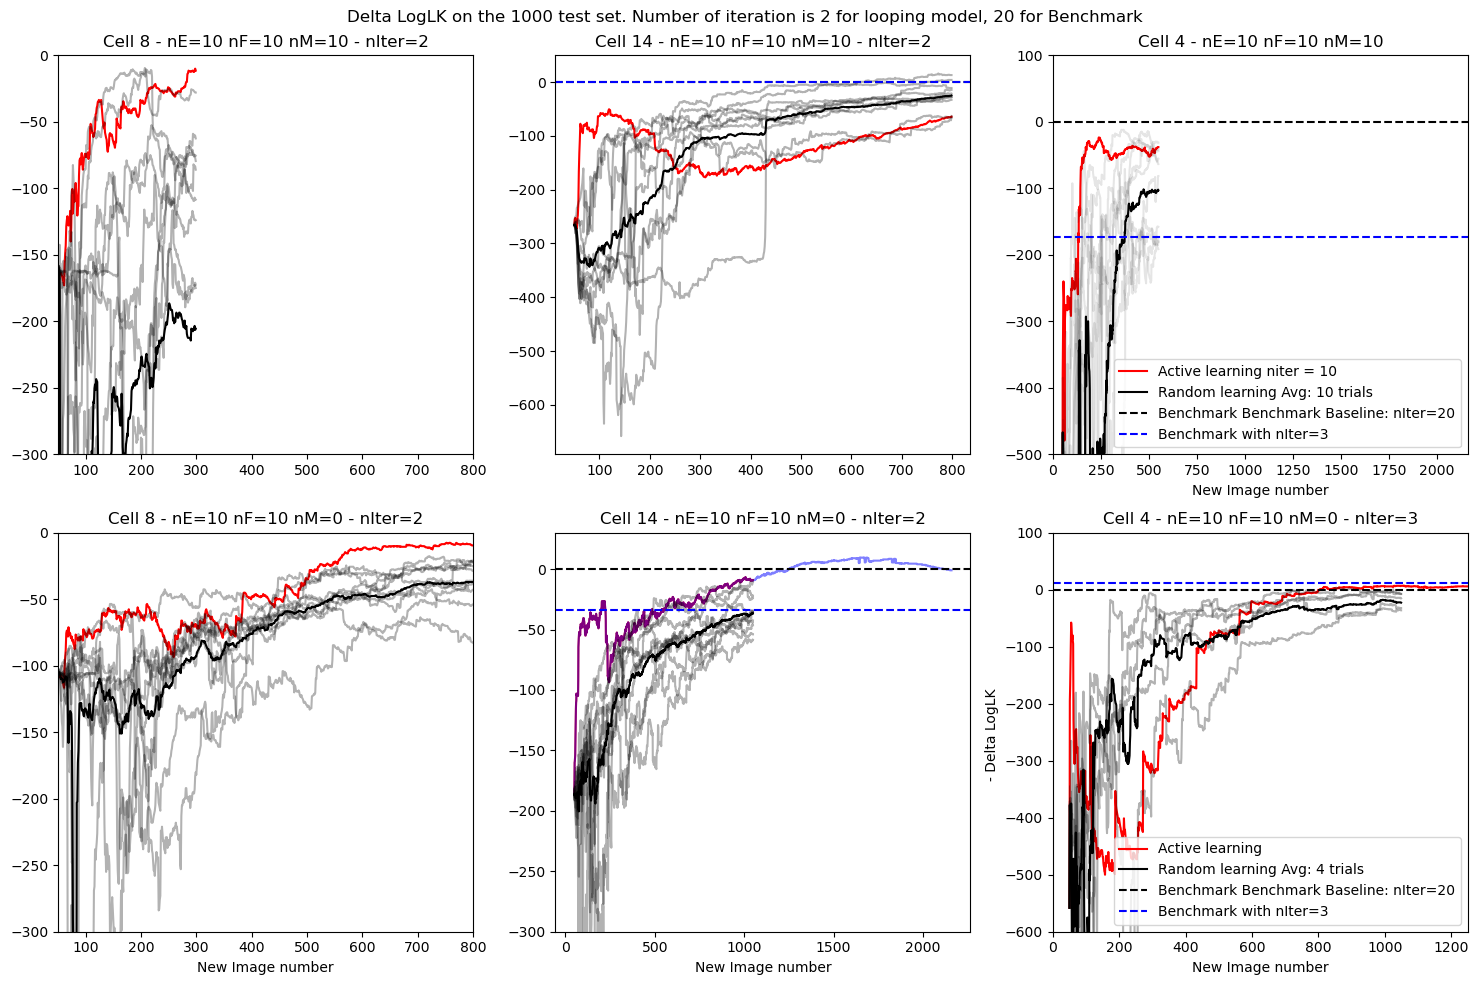

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,10), )#sharex=True)

# region ___________Cell 8  - with M-Step ___________
with open('data/loglk_test_1000_active_cell_8_nstart_50_to_300.pkl', 'rb') as f:
    loglk_cell8_test_1000_active = pickle.load(f)

# Upload the random loop likelihood
# with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_1000.pkl', 'rb') as file:
with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_300.pkl', 'rb') as f:
    loglk_cell8_test_1000_random = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_8.pkl', 'rb') as f:
    loglk_cell8_test_1000_max = pickle.load(f)


xrange = np.arange(50, 50+250)

axes[0,0].plot(xrange, loglk_cell8_test_1000_active.cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell8_test_1000_random.shape[0]):
    axes[0,0].plot(xrange, loglk_cell8_test_1000_random[i,:].cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[0,0].plot(xrange, loglk_cell8_test_1000_random.mean(0).cpu().numpy()-loglk_cell8_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[0,0].set_ylim(-300,0)
axes[0,0].set_xlim(50,800)
axes[0,0].set_title(f'Cell {8} - nE={10} nF={10} nM={10} - nIter=2')
# endregion

# region ___________Cell 8  - no M-Step   ___________
with open('data/loglk_test_1000_active_cell_8_nstart_50_to_800_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_active = pickle.load(f)

# Upload the random loop likelihood
# with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_1000.pkl', 'rb') as file:
with open(f'data/loglk_test_1000_random_cell_8_nstart_50_to_800_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_random = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_8_noM.pkl', 'rb') as f:
    loglk_cell8_noM_test_1000_max = pickle.load(f)


xrange = np.arange(50, 50+750)

axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_active.cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell8_noM_test_1000_random.shape[0]):
    axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_random[i,:].cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[1,0].plot(xrange, loglk_cell8_noM_test_1000_random.mean(0).cpu().numpy()-loglk_cell8_noM_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[1,0].set_ylim(-300,0)
axes[1,0].set_xlim(50,800)
axes[1,0].set_title(f'Cell {8} - nE={10} nF={10} nM={0} - nIter=2')
axes[1,0].set_xlabel('New Image number')
# endregion

# region ___________Cell 14 - with M-Step ___________
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_800.pkl', 'rb') as f:
    loglk_cell14_test_1000_active = pickle.load(f)
with open(f'data/loglk_test_1000_random_cell_14_nstart_50_to_800.pkl', 'rb') as f:
    loglk_cell14_test_1000_random = pickle.load(f)
with open('data/loglk_test_1000_max_cell_14_20iterations.pkl', 'rb') as f:
    loglk_cell14_test_1000_max = pickle.load(f)
with open('data/loglk_test_1000_max_cell_14.pkl', 'rb') as f:
    prev_loglk_cell14_test_1000_max = pickle.load(f)
best_logLK_diff = prev_loglk_cell14_test_1000_max - loglk_cell14_test_1000_max 

xrange = np.arange(50, 50+750)

axes[0,1].plot(xrange, loglk_cell14_test_1000_active.cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), label='Active learning', color='red') 
for i in range(loglk_cell14_test_1000_random.shape[0]):
    axes[0,1].plot(xrange, loglk_cell14_test_1000_random[i,:].cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), color='k', alpha=0.3)     

# Plot the loglk random averaged over rows
axes[0,1].plot(xrange, loglk_cell14_test_1000_random.mean(0).cpu().numpy()-loglk_cell14_test_1000_max.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

# axes[0,1].set_ylim(-300,100)
# axes[0,1].set_xlim(50,1050)
axes[0,1].set_title(f'Cell {14} - nE={10} nF={10} nM={10} - nIter=2')
axes[0,1].axhline(y=0, color='black', linestyle='--', label='Updated Benchmark Baseline: nIter=20')
axes[0,1].axhline(y=best_logLK_diff.cpu().numpy(), color='blue', linestyle='--', label='Benchmark (Previous) on nIter=2')
# endregion

# region ___________Cell 14 - no M-Step   ___________
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_1050_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_active = pickle.load(f) 
with open(f'data/loglk_test_1000_random_cell_14_nstart_50_to_1050_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_random = pickle.load(f)
with open('data/loglk_test_1000_active_cell_14_nstart_50_to_2160_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_active_toend = pickle.load(f)

# Upload the max model likelihood
with open('data/loglk_test_1000_max_cell_14_noM_20iterations.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_max_20iter = pickle.load(f)
with open('data/loglk_test_1000_max_cell_14_noM.pkl', 'rb') as f:
    loglk_cell14_noM_test_1000_max = pickle.load(f)
best_logLK_diff = loglk_cell14_noM_test_1000_max - loglk_cell14_noM_test_1000_max_20iter 


xrange = np.arange(50, 50+1000)
xrange_toend = np.arange(50, 2160)

axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_active.cpu().numpy()-loglk_cell14_noM_test_1000_max_20iter.cpu().numpy(), 
               label='Active learning', color='red') 
axes[1,1].plot(xrange_toend, loglk_cell14_noM_test_1000_active_toend.cpu().numpy()-loglk_cell14_noM_test_1000_max_20iter.cpu().numpy(), 
               label='Active learning to end', color='blue', alpha=0.5)

for i in range(loglk_cell14_noM_test_1000_random.shape[0]):
    axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_random[i,:].cpu().numpy()-loglk_cell14_noM_test_1000_max_20iter.cpu().numpy(), color='k', alpha=0.3)     
# Plot the loglk random averaged over rows
axes[1,1].plot(xrange, loglk_cell14_noM_test_1000_random.mean(0).cpu().numpy()-loglk_cell14_noM_test_1000_max_20iter.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black' )

axes[1,1].set_ylim(-300,30)
# axes[1,1].set_xlim(50,1050)
axes[1,1].set_title(f'Cell {14} - nE={10} nF={10} nM={0} - nIter=2')
axes[1,1].axhline(y=0, color='black', linestyle='--', label='Benchmark Benchmark Baseline: nIter=20')
axes[1,1].axhline(y=best_logLK_diff.cpu().numpy(), color='blue', linestyle='--', label='Benchmark (Previous) on nIter=2')
axes[1,1].set_xlabel('New Image number')
# plt.legend()
# endregion

# region ___________Cell 4 - with M-Step  ___________
with open('data/loglk_test_1000_active_cell_4_nstart_50_to_550_3iter.pkl', 'rb') as f:
    loglk_cell4_test_1000_active_3iter = pickle.load(f)
with open('data/loglk_test_1000_random_cell_4_nstart_50_to_550_3iter.pkl', 'rb') as f:
    loglk_cell4_test_1000_random = pickle.load(f)
print(loglk_cell4_test_1000_random.shape)
with open('data/loglk_test_1000_max_cell_4_3iter.pkl', 'rb') as f:
    loglk_cell4_test_1000_max = pickle.load(f)
with open('data/loglk_test_1000_max_cell_4_20iterations.pkl', 'rb') as f:
    loglk_cell4_test_1000_max_20iter = pickle.load(f)

best_logLK_diff = loglk_cell4_test_1000_max - loglk_cell4_test_1000_max_20iter 

xrange500 = np.arange(50, 550)
axes[0,2].plot(xrange500, loglk_cell4_test_1000_active_3iter.cpu().numpy()-loglk_cell4_test_1000_max_20iter.cpu().numpy(), label=f'Active learning niter = {10}', color='red', )
for i in range(loglk_cell4_test_1000_random.shape[0]):
    axes[0,2].plot(xrange500, loglk_cell4_test_1000_random[i,:].cpu().numpy()-loglk_cell4_test_1000_max_20iter.cpu().numpy(), color='k', alpha=0.1,) 
axes[0,2].plot(xrange500, loglk_cell4_test_1000_random.mean(0).cpu().numpy()-loglk_cell4_test_1000_max_20iter.cpu().numpy(), 
         label=f'Random learning Avg: {10} trials', color='black',)


axes[0,2].set_ylim(-500,100)
axes[0,2].set_xlim(0,2160)
axes[0,2].set_title(f'Cell {4} - nE={10} nF={10} nM={10}')
axes[0,2].axhline(y=0, color='black', linestyle='--', label='Benchmark Benchmark Baseline: nIter=20')
axes[0,2].axhline(y=best_logLK_diff.cpu().numpy(), color='blue', linestyle='--', label='Benchmark with nIter=3')
axes[0,2].set_xlabel('New Image number')
axes[0,2].legend()
# endregion

# region ___________Cell 4 - no M-Step    ___________

with open('data/loglk_test_1000_active_cell_4_nstart_50_to_2160_noM_3iter.pkl', 'rb') as f:
    loglk_cell4_noM_test_1000_active_3iter = pickle.load(f)  
with open('data/2loglk_test_1000_random_cell_4_nstart_50_to_1050.pkl', 'rb') as f: # saved wrong :(
    loglk_cell4_noM_test_1000_random_3iter = pickle.load(f)  
# Upload the max model likelihood both with the same number of iterations or with more ( 20 )
with open('data/loglk_test_1000_max_cell_4_noM_3iter.pkl', 'rb') as f:
    loglk_cell4_test_1000_max_noM = pickle.load(f)
with open('data/loglk_test_1000_max_cell_4_noM_20iterations.pkl', 'rb') as f:
    loglk_cell4_test_1000_max_20iter_noM = pickle.load(f)
best_logLK_diff = loglk_cell4_test_1000_max_noM - loglk_cell4_test_1000_max_20iter_noM 

xrange = np.arange(50, 50+1000)
xrange_toend = np.arange(50, 2160)
# xrange = np.arange(50, 2160)

axes[1,2].plot(xrange_toend, loglk_cell4_noM_test_1000_active_3iter.cpu().numpy()-loglk_cell4_test_1000_max_20iter_noM.cpu().numpy(), 
               label='Active learning', color='red', ) 
# Plot the loglk random averaged over rows
for i in range(5):
    axes[1,2].plot(xrange, loglk_cell4_noM_test_1000_random_3iter[i,:].cpu().numpy()-loglk_cell4_test_1000_max_20iter_noM.cpu().numpy(), color='k', alpha=0.3)     
axes[1,2].plot(xrange, loglk_cell4_noM_test_1000_random_3iter[:4,:].mean(0).cpu().numpy()-loglk_cell4_test_1000_max_20iter_noM.cpu().numpy(), 
         label=f'Random learning Avg: {4} trials', color='black' )

axes[1,2].set_ylim(-600,100)
axes[1,2].set_xlim(0,1250)
axes[1,2].set_title(f'Cell {4} - nE={10} nF={10} nM={0} - nIter=3')
axes[1,2].axhline(y=0, color='black', linestyle='--', label='Benchmark Benchmark Baseline: nIter=20')
axes[1,2].axhline(y=best_logLK_diff.cpu().numpy(), color='blue', linestyle='--', label='Benchmark with nIter=3')
axes[1,2].set_xlabel('New Image number')
axes[1,2].legend()
# endregion

plt.ylabel('- Delta LogLK ')
fig.suptitle('Delta LogLK on the 1000 test set. Number of iteration is 2 for looping model, 20 for Benchmark')
plt.tight_layout()

Giving more time to the benchmark model to reach the correct solution, we get

```active_model m_b mean() = 4.381720158410237```
```active_model V_b mean() = 3.508403057914423```

```benchmark    m_b mean() = 4.741809784102359```
```benchmark    V_b mean() = 3.999350115162007```

### 2. Choice of the Hyperparameters
Having found a good benchmark of performance ( the complete dataset model, trained with enough Iteration to have time to converge to optimal) we can focus on testing.

We need to run tests on:
- [ ] Choice of number of starting dataset. Is the effect better observed with 20 or 50 inducing points?
- [ ] To test the above we need to average out the effect of the actual coice of starting images -> 10 initial configurations for each test
- [ ] To test 10 initial configurations we need to models to be fast, so we have to focus on runs with no M-step

##### Below is a script to estimate the Hyperparameters having only an STA from a checkerboard
Which is what is available in the live experiment

###